<a href="https://colab.research.google.com/github/fahmidjobbi/TP-COLLAB/blob/main/DiffusionModelsLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np
import torch

In [37]:
def sample_batch(batch_size , device='cpu'):
  data, _ = make_swiss_roll(batch_size)
  data= data[ : , [2,0]]/10
  data= data * np.array([1,-1])
  return torch.from_numpy(data).to(device)
data = sample_batch(10000)

In [38]:

print(data)

tensor([[-0.3131,  0.9235],
        [ 0.7867,  0.0108],
        [-0.4806, -0.1265],
        ...,
        [-0.0922, -0.6063],
        [-1.0015, -0.5675],
        [ 0.0562, -0.6347]], dtype=torch.float64)


(-2.0, 2.0)

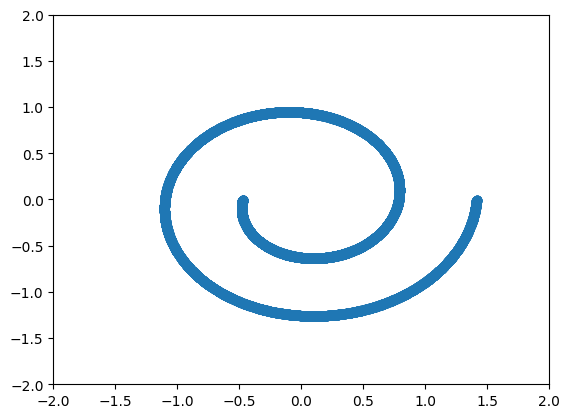

In [39]:
plt.scatter(data[:,0], data[:,1])
plt.xlim([-2,2])
plt.ylim([-2,2])

In [40]:
def forward_process(data,T,betas):
  for t in range(T):

    beta_t=betas[t]
    mu=data * torch.sqrt(1-beta_t)
    std=torch.sqrt(beta_t)
    # sample from q(x_t | x_{t-1}) gaussian distribuation
    data= mu + torch.randn_like(data) * std #data ~ N(mu , std)
  return data


In [41]:
T=40
betas= torch.sigmoid(torch.linspace(-18,10,T)) * (3e-1 - 1e-5) + 1e-5
xTT= forward_process(data, T , betas)

In [42]:
print(xTT.mean(0))
print(xTT.std(0))


tensor([-0.0283, -0.0169], dtype=torch.float64)
tensor([1.0009, 1.0079], dtype=torch.float64)


(-2.0, 2.0)

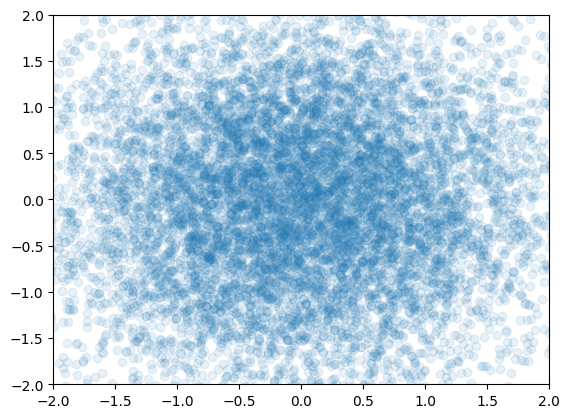

In [43]:
plt.scatter(xTT[:,0].data.numpy(), xTT[:,1].data.numpy(),alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])

In [64]:
from posixpath import dirname
import torch.nn as nn
class DiffusionModel():
  def __init__(self, T,model: nn.Module,dim=2):
    self.betas=torch.sigmoid(torch.linspace(-18,10,T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas=1-self.betas
    self.alphas_bar=torch.cumprod(self.alphas, 0)
    self.T=T
    self.model=model
    self.dim=dim
  def forward_process(self,x0,t=40):
      assert t>0
      t=t-1

      mu=torch.sqrt(self.alphas_bar[t])* x0
      std= torch.sqrt(1-self.alphas_bar[t])
      epsilon=torch.randn_like(x0)

      return mu + epsilon * std
  def reverse_process(self,xT,t):
    assert t>0
    assert self.T<= self.T
    t=t-1
    mu,std=self.model(xT,t)
    epsilon=torch.randn_like(xT)

    return mu + epsilon * std
  def sample(self,batch_size):
    noise=torch.randn((batch_size,self.dim))
    x=noise
    samples=[x]
    for t in range(self.T,0,-1):
      if not (t==1):
        x=self.reverse_process(x,t)
      samples.append(x)
    return samples[::-1]


In [65]:
mlp_model=torch.load('model_paper1.pth')
model=DiffusionModel(40,mlp_model)
x0=sample_batch(10000)
xT= model.forward_process(x0,20)

(-2.0, 2.0)

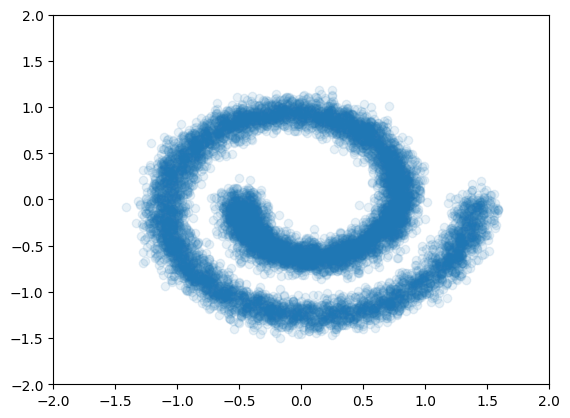

In [66]:
plt.scatter(xT[:,0].data.numpy(), xT[:,1].data.numpy(),alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])

In [67]:
samples=model.sample(1000)

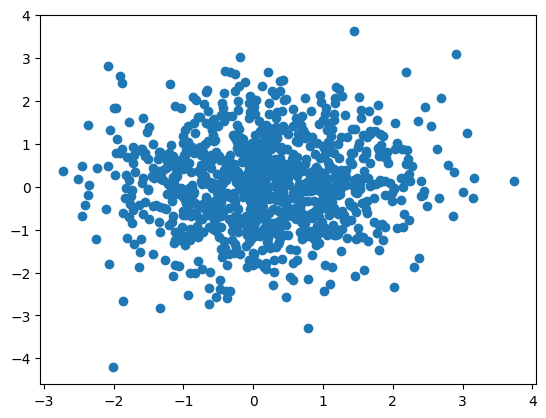

In [70]:
plt.scatter(samples[20][:,0].data.numpy() , samples[20][:,1].data.numpy())

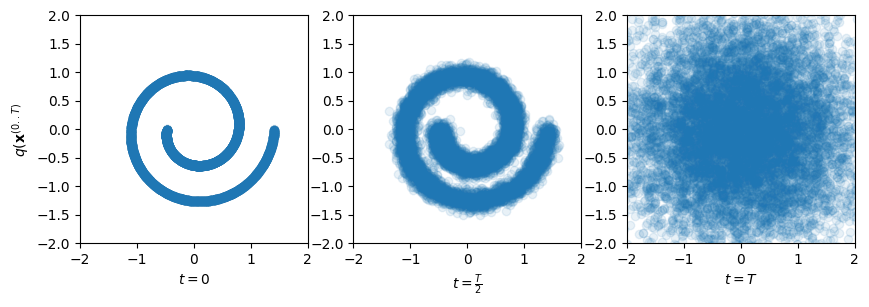

In [71]:
fontsize=14
fig=plt.figure(figsize=(10,3))

dataa =[x0, model.forward_process(x0,20),model.forward_process(x0,40)]
for i in range(3):

  plt.subplot(1,3,1+i)
  plt.scatter(dataa[i][:,0].data.numpy(), dataa[i][:,1].data.numpy(),alpha=0.1)
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.gca().set_aspect('equal')

  if i == 0 : plt.ylabel(r'$q(\mathbf{x}^{(0..T)}$')
  if i == 0 : plt.xlabel(r'$t=0$')
  if i == 1 : plt.xlabel(r'$t=\frac{T}{2}$')
  if i == 2 : plt.xlabel(r'$t=T$')

In [72]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.network_head = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),  # Corrected the typo here
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),  # Corrected the typo here
        )

        self.network_tail = nn.ModuleList(
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, data_dim * 2),
            ) for t in range(N)
        )

    def forward(self, x, t):
        h = self.network_head(x)
        tmp = self.network_tail[t](h)
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std



In [51]:
# Example usage
model = MLP()
x = torch.rand((64, 2))  # Adjust batch_size and data_dim as needed
t = 5 # Example time step
mu, std = model(x, t)
print(mu.shape)
print(std.shape)
model_path = 'model_paper1.pth'
torch.save(model,model_path)

torch.Size([64, 2])
torch.Size([64, 2])


In [ ]:
#reverse process
